<a href="https://colab.research.google.com/github/yvsim001/projekt/blob/main/Kopie_von_AFHQ_Dataset_with_vww_modell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 -m pip install --upgrade tensorflow
!python3 -m pip install --upgrade jupyter matplotlib numpy pandas scipy scikit-learn keras

  Using cached numpy-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.0 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.0 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.0 which is incompatible.
ibis-framework 8.0.0 requires numpy<2,>=1, but you have numpy 2.0.0 which is incompatible.
numba 0.58.1 requires numpy<1.27,>=1.22, but you have numpy 2.0.0 which is incompatible.
rmm-cu12 24.4.0 requir

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.16.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from tensorflow.keras.layers import Layer  # For example, importing Layer from Keras


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import pathlib

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fa3edb1ecb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so: cannot open shared object file: No such file or directory


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
#BATCH_SIZE = 32 # ist eine Gruppe von n Daten aus den Trainingsdaten, die es ermöglicht, die Parameter zu verbessern, basierend auf dem Fehler, der mit diesen Daten berechnet wird.
#EPOCHS = 20 #20 Durchgang durch die Daten(training_daten), um die grundlegenden Parameter zu erhalten(1).
#1 passage= epoch kann 20 Iterationen haben, so dass eine Iteration die Parameter des Modells mit einem Batch von n Daten gleicher Größe aber unterschiedlicher Werte modifiziert.
# Am Ende des Durchlaufs aller Daten(1) wird das trainierte Modell evaluiert und dann mit neuen Daten weiter trainiert (Validierung), um Overfitting zu vermeiden und die Parameter anzupassen(2).
#1 epochs = trainingdatasize/batch_size = n Iterationen = 1 Durchgang.
#Eine Iteration = Lesen eines Stapels von n Daten.


#Der Datensatz wird vorverarbeitet, um auf zu trainieren.
#Bilder, die mindestens eine Person enthalten, die mehr als 2,5% des Quellbildes einnimmt.

In [ ]:
#vw_coco2014_96


In [ ]:
path_to_zip_file='/content/drive/MyDrive/archive.zip'
directory_to_extract_to='/content/drive/MyDrive/unzip'

In [ ]:
#import zipfile
#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#  zip_ref.extractall(directory_to_extract_to)

In [ ]:
BASE_DIR='/content/drive/MyDrive/unzip/afhq'

In [ ]:
import numpy as np

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

def mobilenet_v1():
    # Mobilenet parameters
    input_shape = [150,150,3]
    num_classes = 3
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 9th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 10th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 11th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 12th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = mobilenet_v1()
model.summary()    #Model Details

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 75, 75, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 75, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 75, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 75, 75, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 75, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 38, 38, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 38, 38, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 38, 38, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 38, 38, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 38, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 38, 38, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 38, 38, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 222,051 (867.39 KB)

 Trainable params: 216,579 (846.01 KB)

 Non-trainable params: 5,472 (21.38 KB)

In [ ]:

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
classes = {"cat": "0", "dog": "1", "wild": "2"}
allFilenames = []
allCategories = []
for classElement in classes:
    filenames = os.listdir("/content/drive/MyDrive/unzip/afhq/train/" +classElement)
    allFilenames += [classElement + "/" + file for file in filenames]
    allCategories += [classes[classElement]] * len(filenames)


df = pd.DataFrame({
    'filename': allFilenames,
    'class': allCategories
})

In [ ]:
allFilenames_test = []
allCategories_test = []
for classElement in classes:
    filenames = os.listdir("/content/drive/MyDrive/unzip/afhq/val/" + classElement)
    allFilenames_test += [classElement + "/" + file for file in filenames]
    allCategories_test += [classes[classElement]] * len(filenames)


df_test = pd.DataFrame({
    'filename': allFilenames_test,
    'class': allCategories_test
})

In [ ]:
df_training, df_validation = train_test_split(df, test_size = 0.20)
df_training = df_training.reset_index(drop = True)
df_validation = df_validation.reset_index(drop = True)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'reflect'
)

train_generator = train_datagen.flow_from_dataframe(
    df_training,
    "/content/drive/MyDrive/unzip/afhq/train",
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 11704 validated image filenames belonging to 3 classes.


In [ ]:
df_example = df_training.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    df_example,
    "/content/drive/MyDrive/unzip/afhq/train",
    x_col='filename',
    y_col='class',
    target_size = (150, 150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    "/content/drive/MyDrive/unzip/afhq/train",
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 2926 validated image filenames belonging to 3 classes.


In [ ]:
early_stopping = EarlyStopping(patience=10)

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, factor = 0.5, min_lr = 0.00001)

callbacks = [early_stopping, reduce_lr]

In [ ]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks = callbacks
)

Epoch 1/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 6162s 32s/step - accuracy: 0.4684 - loss: 1.3190 - val_accuracy: 0.3305 - val_loss: 1.6370 - learning_rate: 0.0010
Epoch 2/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.5650 - loss: 1.1948 - val_accuracy: 0.3305 - val_loss: 1.8669 - learning_rate: 0.0010
Epoch 3/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.6015 - loss: 1.1244 - val_accuracy: 0.3681 - val_loss: 1.5637 - learning_rate: 0.0010
Epoch 4/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.6385 - loss: 1.0626 - val_accuracy: 0.6227 - val_loss: 1.1035 - learning_rate: 0.0010
Epoch 5/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.6738 - loss: 0.9837 - val_accuracy: 0.5000 - val_loss: 2.7593 - learning_rate: 0.0010
Epoch 6/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.7103 - loss: 0.9087 - val_accuracy: 0.6347 - val_loss: 1.2664 - learning_rate: 0.0010
Epoch 7/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.7374 - loss: 

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = history.history['loss'],
                    mode='lines+markers',
                    name='Training loss'))
fig.add_trace(go.Scatter(y = history.history['val_loss'],
                    mode='lines+markers',
                    name='Validation loss'))

fig.update_layout(title_text = 'Loss of model')
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = history.history['accuracy'],
                    mode='lines+markers',
                    name='Training accuracy'))
fig.add_trace(go.Scatter(y = history.history['val_accuracy'],
                    mode='lines+markers',
                    name='Validation accuracy'))

fig.update_layout(title_text = 'Accuracy of model')
fig.show()

In [ ]:
#print(f'Anzahl der Iterationen pro Epoch :{len(train_generator)}')
#print(', wobei eine Iteration das Einlesen eines Batches von 32 daten (Iterationen oder Steps_pro_epoch = Anzahl der Trainingsdaten/Batch_size)')

In [ ]:
#print(f'Total training samples: {train_generator.samples}')
#print(f'Total validation samples: {val_generator.samples}')


In [ ]:
#print(train_generator.samples)

In [ ]:
#print(len(train_generator))

In [ ]:
#print(len(val_generator))

In [ ]:
#model = train_epochs(model, train_generator, val_generator, 5, 0.001)

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test,
    "/content/drive/MyDrive/unzip/afhq/val",
    x_col='filename',
    y_col=None,
    class_mode= None,
    target_size = (150, 150),
    batch_size = 64,
    shuffle = False
)

Found 1500 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=int(np.ceil(df_test.shape[0] / 64)))


24/24 ━━━━━━━━━━━━━━━━━━━━ 811s 35s/step


In [ ]:
df_test['prediction'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_test['prediction'] = df_test['prediction'].replace(label_map)
df_test['prediction'] = df_test['prediction'].replace({ '1': 1, '0': 0 })

In [ ]:
fig = go.Figure(data=[go.Bar(x = ['Cat', 'Dog', 'Wild'], y = df_test['prediction'].value_counts())])
fig.update_layout(title_text = 'Distribution of predicted classes')
fig.show()

In [ ]:
df_test['correctPred'] = df_test.apply(lambda x: str(x['class']) == str(x['prediction']), axis=1)

In [ ]:
fig = go.Figure(data=[go.Bar(x = ['Correct prediction', 'False prediction'], y = df_test.correctPred.value_counts())])
fig.update_layout(title_text = 'Correct prediction vs False prediction')
fig.show()

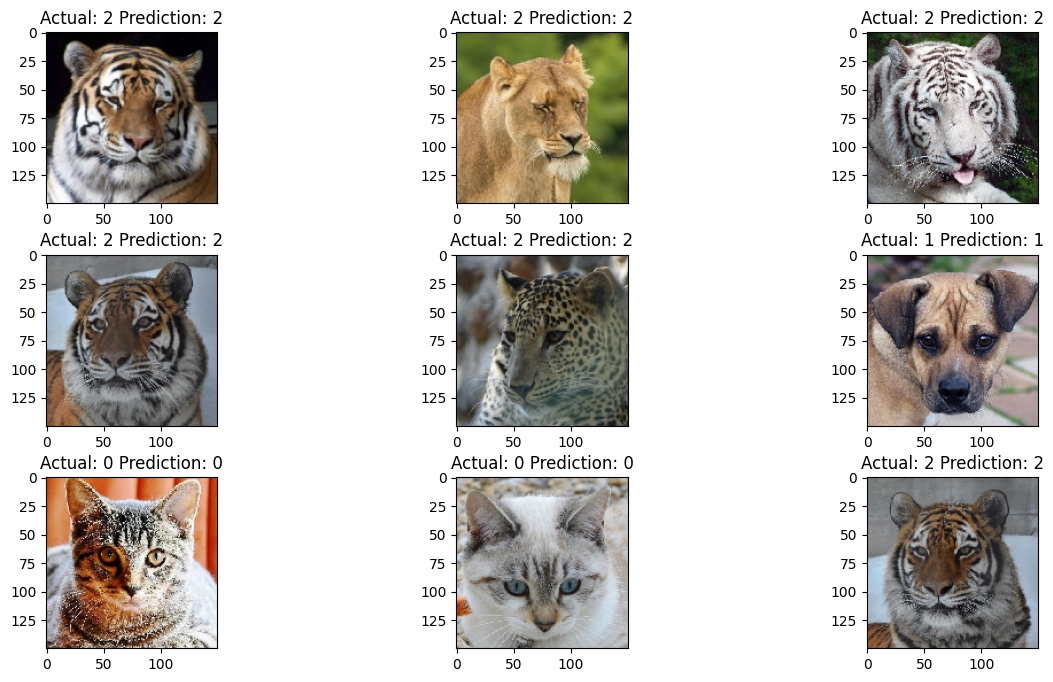

In [ ]:
import random
randomlist = []
for i in range(0,9):
    n = random.randint(0,len(df_test))
    randomlist.append(n)

fig = plt.figure(figsize=(15,8))
gs1 = gridspec.GridSpec(3, 3)
axs = []
for num in range(len(randomlist)):
    row = df_test.iloc[[randomlist[num]]]
    filename = row['filename'][randomlist[num]]
    img = load_img("/content/drive/MyDrive/unzip/afhq/val/"+filename, target_size= (150, 150))
    axs.append(fig.add_subplot(gs1[num - 1]))
    axs[-1].imshow(img)
    axs[-1].set_title("Actual: " + df_test[df_test["filename"] == filename]["class"].iloc[0] + " Prediction: " + str(row['prediction'][randomlist[num]]) )
fig.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/trained_models/vww_512_2.h5')
#model.save('/content/drive/MyDrive/trained_models/vww_512')
model.save('/content/drive/MyDrive/trained_models/vww_512_2.keras')
model.export('/content/drive/MyDrive/trained_models/vww_512_2')

Saved artifact at '/content/drive/MyDrive/trained_models/vww_512_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140342727902656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727901952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727903888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727906704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727905472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727905648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727909168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727909696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727901600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140342727914624: TensorSpec(shape=(), dtype=tf.resour

In [ ]:

import cv2
import numpy as np

# Bild laden
img_link='/content/drive/MyDrive/RANDOM_IMAGE_FOR_TEST/hund.jpg'

IMAGE_SIZE  =150

def load_preprocess_image(image_path):

  image = cv2.imread(image_path)
  # Bild in Graustufen konvertieren (falls es noch nicht graustufig ist)
  #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Bild auf 150*150 skalieren
  resized_image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

  # Bild in ein numpy Array konvertieren
  array = np.array(resized_image)

  # Optional: Normalisierung der Pixelwerte zwischen 0 und 1
  normalized_array = array *(1. / 255)

  # Überprüfen, ob das Array die gewünschte Größe hat
  print(normalized_array.shape)

  # Das Bild in die erwartete Form bringen (1, 150, 150)
  input_image = normalized_array.reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)

  return input_image


In [ ]:
# Überprüfen der Form des Eingabe-Arrays
print(load_preprocess_image(img_link).shape)

(150, 150, 3)
(1, 150, 150, 3)


In [ ]:
train_dir=r"/content/drive/MyDrive/unzip/afhq/train"

In [ ]:
classlist=os.listdir(train_dir)# Note per python documentation list_dir returns an arbitrary ordered list
sorted_classlist=sorted(classlist, reverse=True)
train_data=tf.keras.utils.image_dataset_from_directory(train_dir, labels='inferred', label_mode='categorical',  class_names=None,
                                                        color_mode='rgb', batch_size=32,  image_size=(224,224), shuffle=False,
                                                        seed=None,  validation_split=None, subset=None,    interpolation='bilinear',
                                                        follow_links=False,   crop_to_aspect_ratio=False)
reverse_train_data=tf.keras.utils.image_dataset_from_directory(train_dir, labels='inferred', label_mode='categorical',  class_names=sorted_classlist,
                                                        color_mode='rgb', batch_size=32,  image_size=(224,224), shuffle=False,
                                                        seed=None,  validation_split=None, subset=None,    interpolation='bilinear',
                                                        follow_links=False,   crop_to_aspect_ratio=False)
class_names=train_data.class_names
reverse_class_names=reverse_train_data.class_names
print('{0:^25s}{1:^25s}{2:^25s}'.format('CLASS NAMES', 'REVERSE CLASS NAMES', 'SORTED CLASS LIST'))
for i in range (len(class_names)):
    print('{0:^25s}{1:^25s}{2:^25s}'.format(class_names[i], reverse_class_names[i], sorted_classlist[i]))

Found 14630 files belonging to 3 classes.
Found 14630 files belonging to 3 classes.
       CLASS NAMES          REVERSE CLASS NAMES       SORTED CLASS LIST    
           cat                     wild                     wild           
           dog                      dog                      dog           
          wild                      cat                      cat           


In [ ]:
def predict_image_class(model, image_path, class_names):
    processed_image = load_preprocess_image(image_path)
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions, axis=-1)[0]  # since we assume a single image, remove batch dimension
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name


(150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted class is: dog


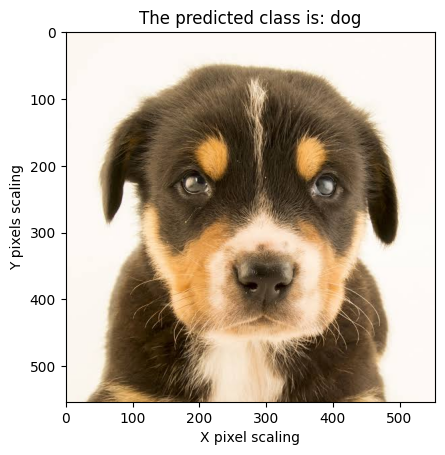

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

image_path = img_link
class_names = ['cat', 'dog', 'wild']  # modify as per your classes
predicted_name = predict_image_class(model, image_path, class_names)
print(f"The predicted class is: {predicted_name}")


plt.title(f"The predicted class is: {predicted_name}")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread(image_path)
plt.imshow(image)
plt.show()

(150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
The predicted class is: wild


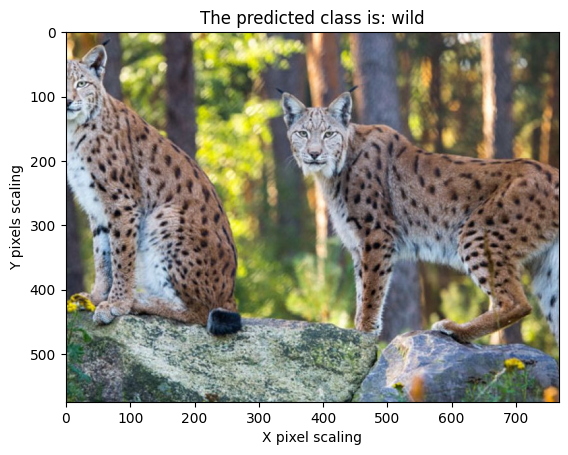

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

image_path_2 = "/content/drive/MyDrive/RANDOM_IMAGE_FOR_TEST/wild.jpg"



class_names = ['cat', 'dog', 'wild']  # modify as per your classes

predicted_name_2 = predict_image_class(model, image_path_2, class_names)
print(f"The predicted class is: {predicted_name_2}")

plt.title(f"The predicted class is: {predicted_name_2}")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread(image_path_2)
plt.imshow(image)
plt.show()

(150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
The predicted class is: wild


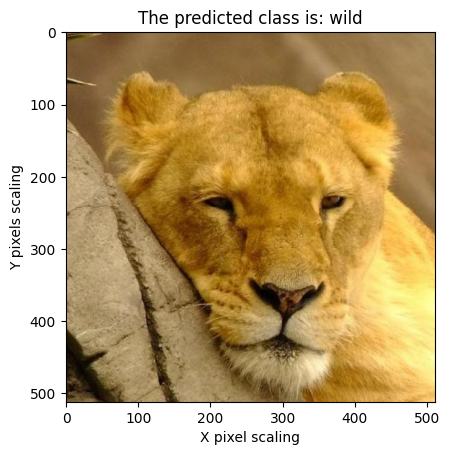

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

image_path_3 = "/content/drive/MyDrive/unzip/afhq/train/wild/pixabay_wild_001253.jpg"
class_names = ['cat', 'dog', 'wild']  # modify as per your classes
predicted_name_3 = predict_image_class(model, image_path_3, class_names)
print(f"The predicted class is: {predicted_name_3}")

plt.title(f"The predicted class is: {predicted_name_3}")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread(image_path_3)
plt.imshow(image)
plt.show()

In [ ]:
y_pred_probabilities = model.predict(load_preprocess_image(image_path))
y_pred_classes = y_pred_probabilities.argmax(axis=-1)

(150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [ ]:
print(y_pred_classes[0])

1


In [ ]:
print(class_names[y_pred_classes[0]])

dog


In [ ]:
!wget https://media.4-paws.org/5/4/4/c/544c2b2fd37541596134734c42bf77186f0df0ae/VIER%20PFOTEN_2017-10-20_164-3854x2667-1920x1329.jpg

--2024-06-30 13:21:00--  https://media.4-paws.org/5/4/4/c/544c2b2fd37541596134734c42bf77186f0df0ae/VIER%20PFOTEN_2017-10-20_164-3854x2667-1920x1329.jpg
Resolving media.4-paws.org (media.4-paws.org)... 116.202.15.201
Connecting to media.4-paws.org (media.4-paws.org)|116.202.15.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288397 (282K) [image/jpeg]
Saving to: ‘VIER PFOTEN_2017-10-20_164-3854x2667-1920x1329.jpg’

VIER PFOTEN_2017-10 100%[===================>] 281.64K   334KB/s    in 0.8s    

2024-06-30 13:21:02 (334 KB/s) - ‘VIER PFOTEN_2017-10-20_164-3854x2667-1920x1329.jpg’ saved [288397/288397]



(150, 150, 3)


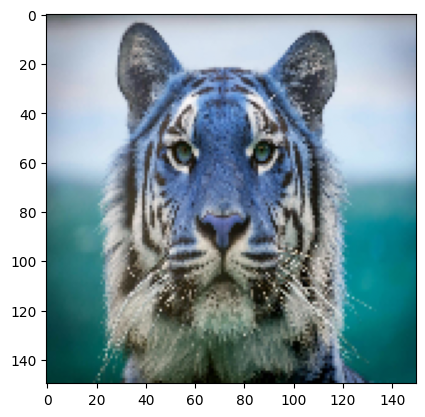

In [ ]:
from matplotlib import pyplot as plt
img =  load_preprocess_image('VIER PFOTEN_2017-10-20_164-3854x2667-1920x1329.jpg')
plt.imshow(img[0,:,:,:])

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

image_path_3 = img
class_names = ['cat', 'dog', 'wild']  # modify as per your classes
predicted_name_3 = predict_image_class(model, image_path_3, class_names)
print(f"The predicted class is: {predicted_name_3}")

plt.title(f"The predicted class is: {predicted_name_3}")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread(image_path_3)
plt.imshow(image)
plt.show()

TypeError: Can't convert object to 'str' for 'filename'